In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import torchvision
from torchsummary import summary
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt

torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Fine-Tuning
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = model.to(device)

num_ftrs = model.fc.in_features
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,bias=False) # change input channel to grayscale
model.fc = nn.Linear(num_ftrs, 15) # output 15

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

a = summary(model, input_size=(3, 224, 224))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            3,136
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

In [2]:
class CustomDataset(Dataset):
    def __init__(self, k,l, csv_file ='data/chinese-mnist/chinese_mnist.csv'):
        self.df = pd.read_csv(csv_file)
        self.k= {'九':int(9),'十':int(10),'百':int(11),'千':int(12),'万':int(13),'亿':int(14),'零':int(0),'一':int(1),'二':int(2),'三':int(3),'四':int(4),'五':int(5),'六':int(6),'七':int(7),'八':int(8)}
        self.target = 'character'
        self.features = ['suite_id','sample_id','code',]
        self.labels   = np.asarray(self.df.iloc[:, 4])
        self.y = df[self.target]
        self.X = df.drop(self.target, axis =1)
        self.transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
        ])

    def __getitem__(self,idx):
        single_image_label = self.labels[idx]
        class_id = self.k[single_image_label]
        img = Image.open(f"data/chinese-mnist/data/data/input_{self.X.iloc[idx, 0]}_{self.X.iloc[idx, 1]}_{self.X.iloc[idx, 2]}.jpg")
        if self.transform:
            img = self.transform(img)
        img = np.array(img) # convert to np.array
        
        return img, class_id

    def __len__(self):
        return len(self.X)

df = pd.read_csv('data/chinese-mnist/chinese_mnist.csv',sep=',')
    
train_df = df.groupby('value').apply(lambda x: x.sample(700, random_state=42)).reset_index(drop=True)
x_train, y_train  = train_df.iloc[:, :-2], train_df.iloc[:, -2]

test_df  = df.groupby('value').apply(lambda x: x.sample(300, random_state=42)).reset_index(drop=True)
x_test, y_test    = test_df.iloc[:, :-2], test_df.iloc[:, -2]

#create train dataset and test dataset 
train_ds = CustomDataset(x_train, y_train)
trainloader = DataLoader(dataset=train_ds,batch_size=32, shuffle=True)

test_ds = CustomDataset(x_test, y_test)
testloader = DataLoader(test_ds, batch_size=32, shuffle=True)

image_datasets = {
    'train': train_ds,
    'validation': test_ds
}

dataloaders = {
    'train': trainloader,
    'validation': testloader
}

In [3]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train','validation']:
            
            y_pred = []
            y_true = []
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                model = model.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                
                if phase == 'validation':
                    y_pred.extend(preds.data.cpu().numpy())
                    y_true.extend(labels.data.cpu().numpy())
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return y_true,y_pred,model

In [4]:
y_true,y_pred,model_trained = train_model(model, criterion, optimizer, num_epochs=1)

Epoch 1/3
----------
train loss: 0.3166, acc: 0.9315
validation loss: 0.0231, acc: 0.9968
Epoch 2/3
----------
train loss: 0.0291, acc: 0.9965
validation loss: 0.0089, acc: 0.9987
Epoch 3/3
----------
train loss: 0.0157, acc: 0.9980
validation loss: 0.0048, acc: 0.9995


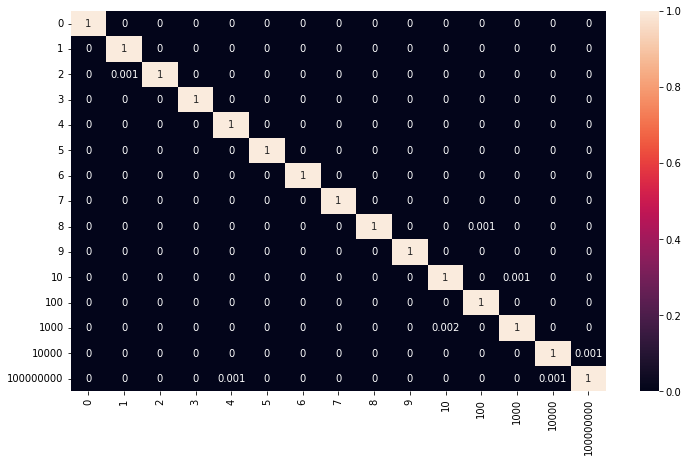

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

#classes = ('零','一','二','三','四','五','六','七','八','九','十','百','千','万','亿')
classes = ('0','1','2','3','4','5','6','7','8','9','10','100','1000','10000','100000000')

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *15, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('cf-chinese-mnist-resnet18.png')

In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000
           2       1.00      1.00      1.00      1000
           3       1.00      1.00      1.00      1000
           4       1.00      1.00      1.00      1000
           5       1.00      1.00      1.00      1000
           6       1.00      1.00      1.00      1000
           7       1.00      1.00      1.00      1000
           8       1.00      1.00      1.00      1000
           9       1.00      1.00      1.00      1000
          10       1.00      1.00      1.00      1000
          11       1.00      1.00      1.00      1000
          12       1.00      1.00      1.00      1000
          13       1.00      1.00      1.00      1000
          14       1.00      1.00      1.00      1000

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00   